# Предсказание показаний состояния пациента

### Данные
Данные в файле covid_flow.pkl включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

Многомерные временные ряды, описывающие состояние пациента (интервал неделя)
План лечения (препараты и процедуры) для каждого пациента
Исходы лечения

### Переменные 
_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

### Задача
Прогноз значения индикаторов состояния пациента (результаты анализов)

Таргеты – признаки с префиксами _dinam_fact.
Факторы – предыдущие значения (кроме _tar), текущее состояние

На выходе получаем класс, который умеет принимать информацию о прошлых состояниях пациента, и прогнозировать следующее.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [56]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

In [57]:
df.iloc[:, 43:47]

трансфузия_dinam_control  оксигенотерапия_dinam_control  \
case    t_point                                                            
GACAAcY 0                               0                              1   
        1                               0                              1   
        2                               0                              1   
        3                               0                              1   
GACAAnf 0                               0                              0   
...                                   ...                            ...   
GACBB;O 0                               0                              0   
        1                               0                              0   
GACXAAB 0                               0                              0   
        1                               0                              0   
        2                               0                              0   

                 НИВЛ_dinam_control  ИВЛ_dinam_control  
case    t_point                                         
GACAAcY 0                         0                  0  
        1                         0                  0  
        2                         0                  0  
        3                         0                  0  
GACAAnf 0                         0                  0  
...                             ...                ...  
GACBB;O 0                         0                  0  
        1                         0                  0  
GACXAAB 0                         0                  0  
        1                         0                  0  
        2                         0                  0  

[6188 rows x 4 columns]

# Predict next period by last one

In [58]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

### Data preparation 

Our suggestion is to divide history by 3 periods

Count of patients: 1992


<AxesSubplot: >

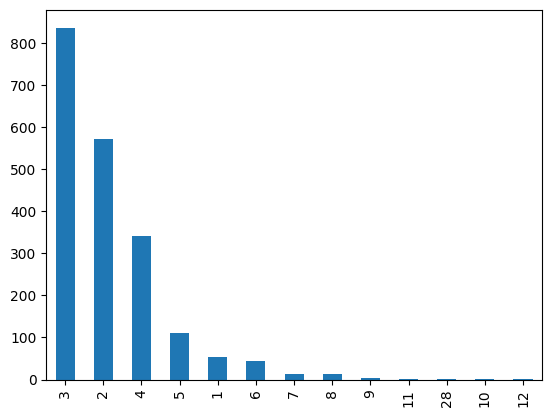

In [59]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

#### Scaling and imputing

Scale values as (x-min(x))/(max(x)-min(x))

Impute NaN values using MICE method with IterativeImputer on Linear regression as estimator 

Divide on train, test, validation splits

#### Function which shows results of model

In [60]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)

    r2_scor = r2_score(y_test, y_pred, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.append(mse_score)
    table.append(r2_scor)

    df_score = pd.DataFrame(table, ["MSE", "R2"], columns=df.columns[29:42])
    df_score.to_csv("reports_w3/"+model.name+".csv")
    model.save("models_w3/"+model.name)
    display(df_score)
    plt.show()
    

## Train Models

#### Window 3

In [61]:
import prepare_data_covid as datacovid
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_dynamic(df_input=df, window=3)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train, y_train), (X_test[1:], y_test[1:]), (X_val[1:], y_val[1:])
X_train.shape

TRAIN shape:  (712, 3, 13)
TEST shape:  (89, 13)
VAL shape:  (89, 13)


(712, 3, 13)

#### FNN

Model: "Faltten1Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 39)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                1280      
                                                                 
 dense_38 (Dense)            (None, 13)                429       
                                                                 
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - 0s 4ms/step - loss: 0.2048 - val_loss: 0.0968
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0302
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0224
Epoch 4/50
23/23 [===

INFO:tensorflow:Assets written to: models_w3/Faltten1Layer\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001607,0.000401,0.018579,0.011722,0.001075,0.004698,0.005571,0.007157,0.007575,0.001530,0.039253,0.014686,0.005831
R2,-0.842065,-4.859294,0.036130,-0.176851,0.198630,-0.043448,0.604598,0.016958,0.304499,0.964744,-0.147239,0.086467,0.565617


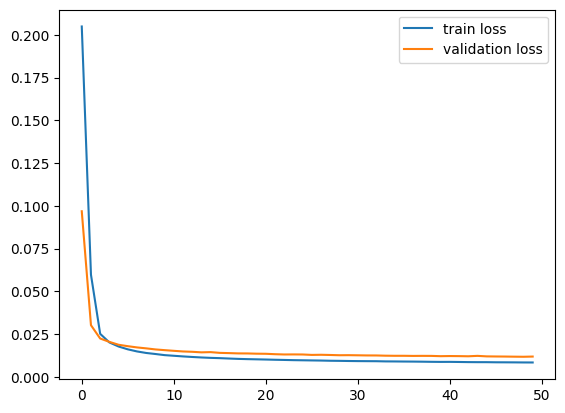

In [62]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW=X_train.shape[1]
model = Sequential(name="Faltten1Layer")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten2Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 39)                0         
                                                                 
 dense_39 (Dense)            (None, 32)                1280      
                                                                 
 dense_40 (Dense)            (None, 13)                429       
                                                                 
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - 0s 4ms/step - loss: 0.1218 - val_loss: 0.0477
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0238
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0198
Epoch 4/50
23/23 [==

INFO:tensorflow:Assets written to: models_w3/Faltten2Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001439,0.000461,0.017301,0.011473,0.001411,0.004296,0.006072,0.005554,0.008113,0.001781,0.040401,0.015598,0.005206
R2,-0.649508,-5.727863,0.102445,-0.151821,-0.051686,0.045993,0.569077,0.237063,0.255148,0.958958,-0.180795,0.029739,0.612175


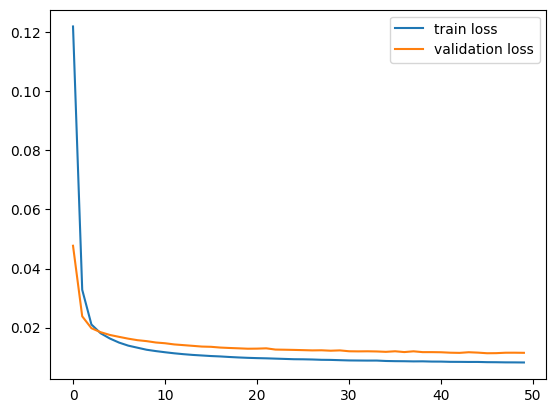

In [63]:
model = Sequential(name="Faltten2Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten3Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 39)                0         
                                                                 
 dense_41 (Dense)            (None, 32)                1280      
                                                                 
 dense_42 (Dense)            (None, 32)                1056      
                                                                 
 dense_43 (Dense)            (None, 32)                1056      
                                                                 
 dense_44 (Dense)            (None, 13)                429       
                                                                 
Total params: 3,821
Trainable params: 3,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] 

INFO:tensorflow:Assets written to: models_w3/Faltten3Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000963,0.000222,0.017848,0.010382,0.000829,0.004690,0.005793,0.007064,0.007823,0.001156,0.039236,0.014538,0.006254
R2,-0.103985,-2.238386,0.074026,-0.042316,0.382221,-0.041601,0.588864,0.029742,0.281709,0.973368,-0.146763,0.095720,0.534100


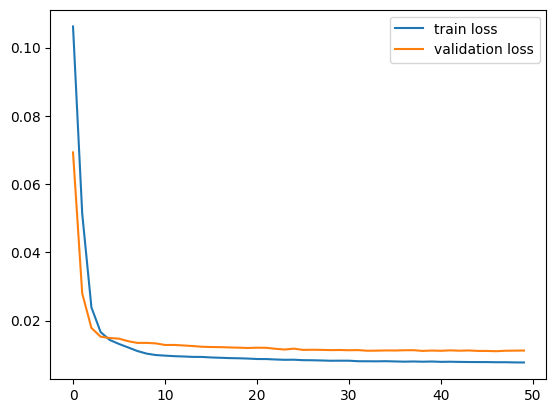

In [64]:
model = Sequential(name="Faltten3Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten4Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 39)                0         
                                                                 
 dense_45 (Dense)            (None, 32)                1280      
                                                                 
 dense_46 (Dense)            (None, 32)                1056      
                                                                 
 dense_47 (Dense)            (None, 32)                1056      
                                                                 
 dense_48 (Dense)            (None, 13)                429       
                                                                 
Total params: 3,821
Trainable params: 3,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] 

INFO:tensorflow:Assets written to: models_w3/Faltten4Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000901,0.000170,0.018022,0.009698,0.001038,0.004560,0.005870,0.006731,0.007801,0.000752,0.037677,0.014730,0.004884
R2,-0.032627,-1.489949,0.065038,0.026423,0.226361,-0.012683,0.583386,0.075416,0.283751,0.982670,-0.101202,0.083789,0.636151


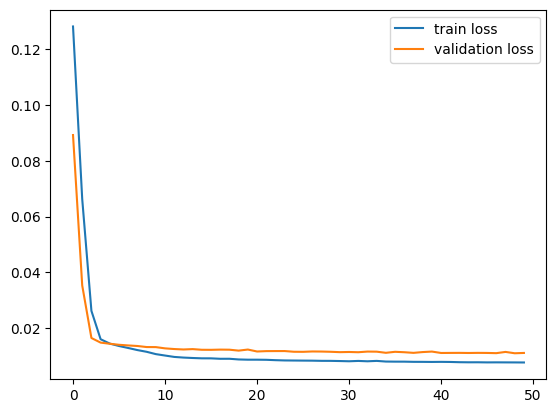

In [65]:
model = Sequential(name="Faltten4Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten4Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 39)                0         
                                                                 
 dense_66 (Dense)            (None, 32)                1280      
                                                                 
 dense_67 (Dense)            (None, 64)                2112      
                                                                 
 dense_68 (Dense)            (None, 64)                4160      
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dense_70 (Dense)            (None, 64)                4160      
                                                                 
 dense_71 (Dense)            (None, 32)             

INFO:tensorflow:Assets written to: models_w3/Faltten4Layers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001113,0.000441,0.018161,0.011743,0.001035,0.004601,0.005918,0.006185,0.007456,0.000389,0.036908,0.014634,0.005449
R2,-0.275213,-5.448500,0.057822,-0.178933,0.228231,-0.021845,0.579988,0.150366,0.315397,0.991030,-0.078714,0.089760,0.594058


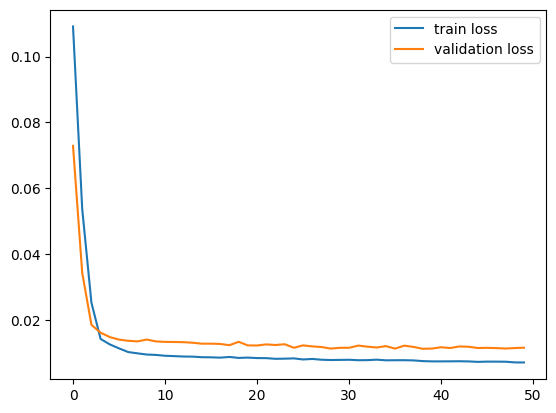

In [83]:
model = Sequential(name="Faltten4Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=8
model = Sequential(name="Faltten3Layers_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=4
model = Sequential(name="Faltten3Layers_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=2
model = Sequential(name="Faltten3Layers_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=1
model = Sequential(name="Faltten3Layers_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

#### RNN

Simple RNN with linear activation 

Model: "SimpleRNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 13)                351       
                                                                 
 dense_49 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001729,0.001448,0.018383,0.010879,0.002485,0.004943,0.014024,0.006550,0.007234,0.005121,0.039227,0.016260,0.011408
R2,-0.980942,-20.150239,0.046310,-0.092218,-0.851939,-0.097920,0.004729,0.100307,0.335790,0.881965,-0.146482,-0.011436,0.150096


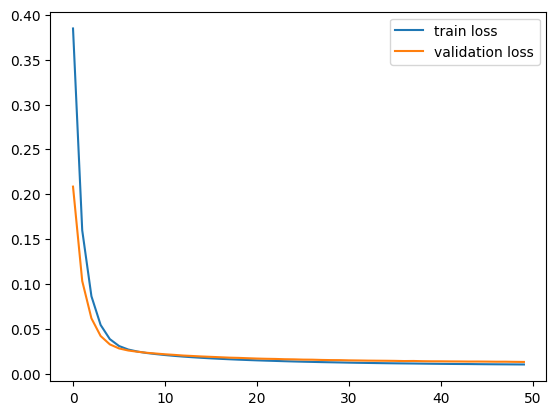

In [66]:
model = Sequential(name="SimpleRNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN sigmoid

Model: "SimpleRNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_50 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001145,0.000584,0.017844,0.010279,0.000642,0.003739,0.012340,0.007522,0.010502,0.009842,0.035460,0.012141,0.007694
R2,-0.311777,-7.531865,0.074251,-0.031988,0.521456,0.169544,0.124208,-0.033257,0.035813,0.773155,-0.036392,0.244804,0.426770


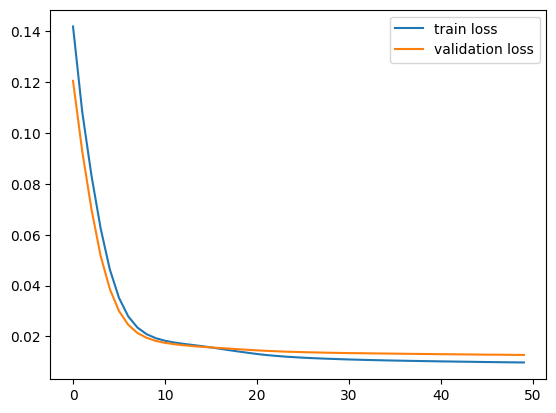

In [67]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="SimpleRNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN with Tanh activation

Model: "SimpleRNN13_Tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 13)                351       
                                                                 
 dense_51 (Dense)            (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13_Tanh\assets


INFO:tensorflow:Assets written to: models_w3/SimpleRNN13_Tanh\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000829,0.001112,0.016972,0.009581,0.000644,0.003559,0.010766,0.007218,0.009317,0.006541,0.035427,0.014364,0.012889
R2,0.049811,-15.251670,0.119473,0.038110,0.520361,0.209468,0.235928,0.008551,0.144580,0.849240,-0.035426,0.106532,0.039728


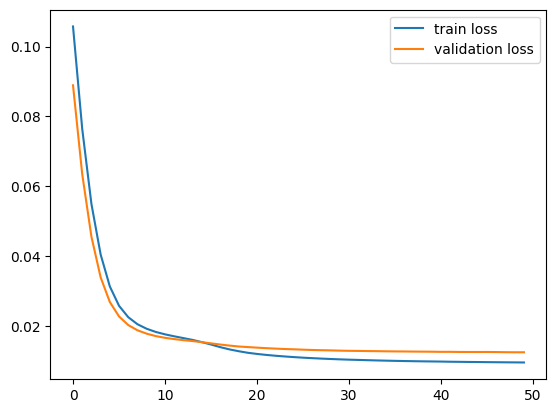

In [68]:
model = Sequential(name="SimpleRNN13_Tanh")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),  verbose=0)
show_results(X_test, y_test, model, history)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_52 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000915,0.000087,0.017947,0.009525,0.000943,0.004867,0.005387,0.005634,0.007678,0.000617,0.036818,0.014881,0.004449
R2,-0.048301,-0.265732,0.068914,0.043778,0.297399,-0.080951,0.617717,0.226046,0.295022,0.985778,-0.076081,0.074370,0.668512


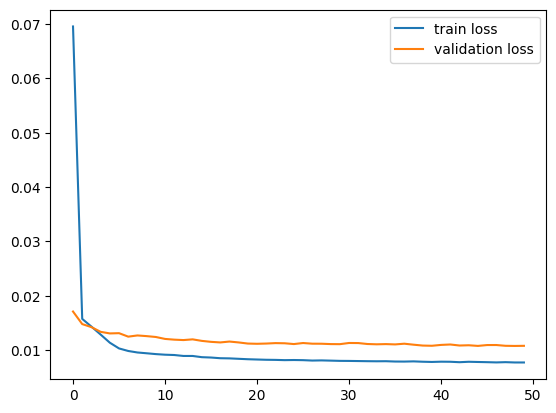

In [69]:
BATCH_SIZE=8

model = Sequential(name="6_LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (4, 13)                   1404      
                                                                 
 dense_53 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000869,0.000083,0.017945,0.009701,0.000920,0.004561,0.005160,0.005629,0.007012,0.000761,0.036234,0.014882,0.004504
R2,0.004484,-0.210359,0.069013,0.026097,0.314451,-0.013031,0.633815,0.226789,0.356203,0.982459,-0.059022,0.074313,0.664443


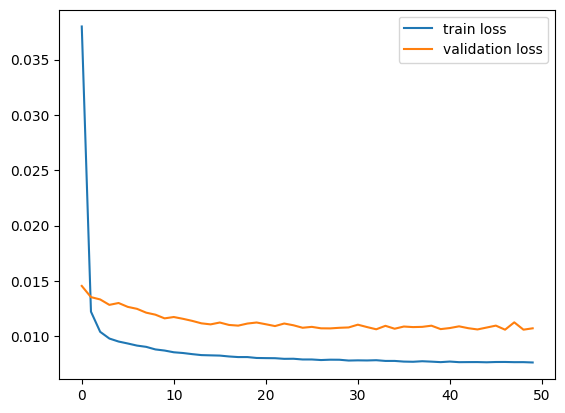

In [70]:
BATCH_SIZE=4

model = Sequential(name="6_LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (2, 13)                   1404      
                                                                 
 dense_54 (Dense)            (2, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000853,0.000056,0.017142,0.009931,0.000946,0.003957,0.004853,0.005639,0.007086,0.000917,0.040813,0.014337,0.005519
R2,0.022387,0.178292,0.110693,0.003005,0.295096,0.121161,0.655619,0.225480,0.349452,0.978865,-0.192836,0.108175,0.588837


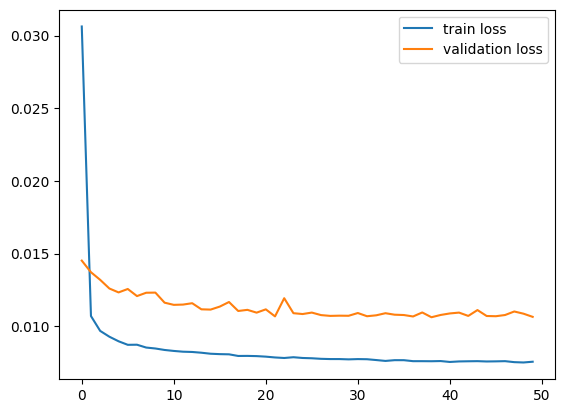

In [71]:
BATCH_SIZE=2

model = Sequential(name="6_LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (1, 13)                   1404      
                                                                 
 dense_55 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000956,0.000147,0.017791,0.009992,0.001008,0.004310,0.005337,0.005741,0.006760,0.000282,0.035267,0.015077,0.005569
R2,-0.095233,-1.150451,0.077024,-0.003100,0.248720,0.042731,0.621262,0.211371,0.379306,0.993507,-0.030739,0.062167,0.585110


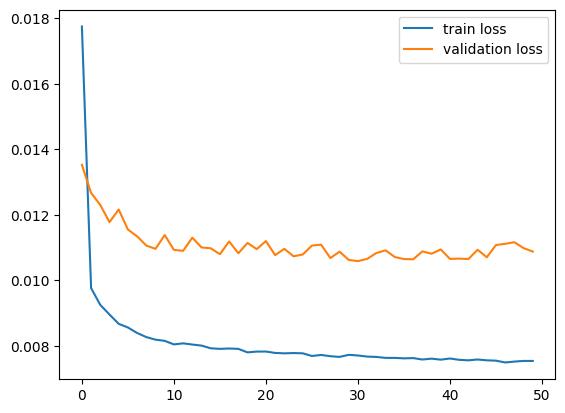

In [72]:
BATCH_SIZE=1

model = Sequential(name="6_LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

### LSTM

LSTM 13 units and linear

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 13)                1404      
                                                                 
 dense_56 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001064,0.000216,0.017828,0.009807,0.001070,0.004363,0.006863,0.006260,0.008020,0.002203,0.037809,0.014815,0.006592
R2,-0.219316,-2.149532,0.075096,0.015429,0.202688,0.031054,0.512950,0.140091,0.263686,0.949235,-0.105049,0.078493,0.508926


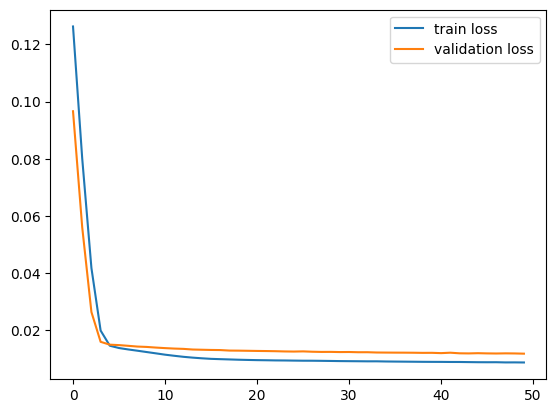

In [73]:
model = Sequential(name="LSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTMWithMore Units

Model: "LSTM32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 32)                5888      
                                                                 
 dense_57 (Dense)            (None, 13)                429       
                                                                 
Total params: 6,317
Trainable params: 6,317
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM32\assets


INFO:tensorflow:Assets written to: models_w3/LSTM32\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000960,0.000328,0.017842,0.009720,0.001039,0.004684,0.005634,0.006398,0.007770,0.001138,0.037277,0.015040,0.004785
R2,-0.100419,-3.793765,0.074373,0.024162,0.225502,-0.040219,0.600126,0.121103,0.286636,0.973770,-0.089485,0.064486,0.643477


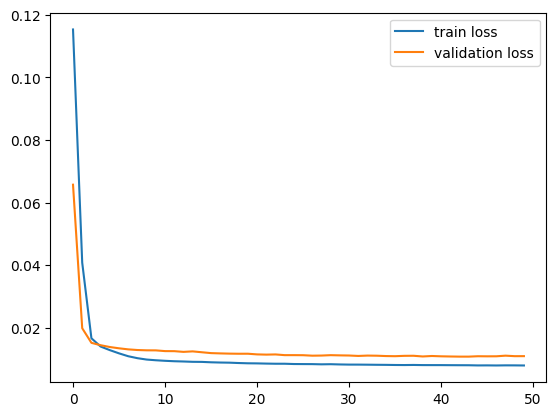

In [74]:
model = Sequential(name="LSTM32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "LSTM64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                19968     
                                                                 
 dense_58 (Dense)            (None, 13)                845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM64\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000890,0.000292,0.017943,0.009743,0.000960,0.004696,0.005066,0.005795,0.007270,0.000917,0.036999,0.015239,0.005050
R2,-0.019945,-3.266594,0.069120,0.021827,0.284811,-0.042976,0.640492,0.204038,0.332489,0.978858,-0.081377,0.052120,0.623744


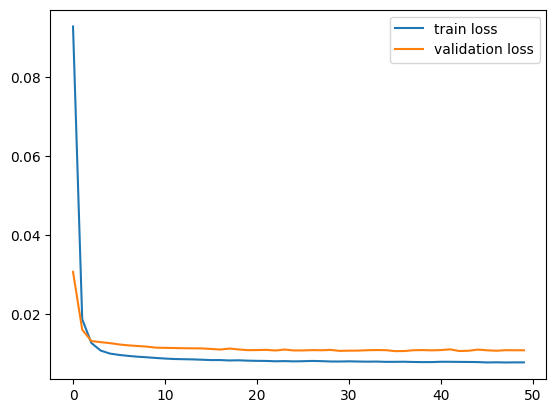

In [75]:
model = Sequential(name="LSTM64")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM with batch

Model: "LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (8, 13)                   1404      
                                                                 
 dense_59 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000818,0.000102,0.017732,0.009895,0.001106,0.004914,0.005541,0.006069,0.007752,0.000781,0.036309,0.014735,0.005520
R2,0.062121,-0.489133,0.080064,0.006591,0.176023,-0.091324,0.606755,0.166317,0.288295,0.981990,-0.061194,0.083447,0.588728


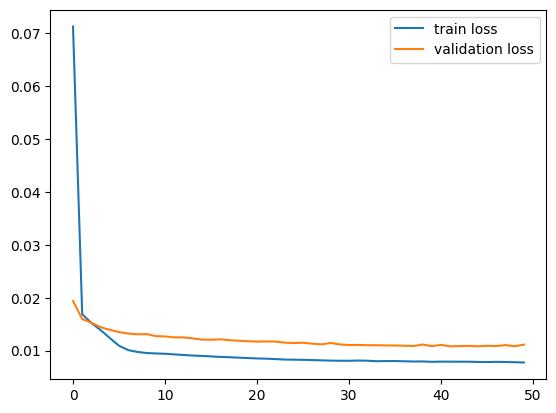

In [76]:
BATCH_SIZE=8

model = Sequential(name="LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (4, 13)                   1404      
                                                                 
 dense_60 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000815,0.000098,0.018257,0.010310,0.000926,0.004649,0.005189,0.005753,0.007059,0.001927,0.039116,0.015198,0.005279
R2,0.066259,-0.434771,0.052813,-0.035063,0.309630,-0.032620,0.631751,0.209759,0.351860,0.955585,-0.143239,0.054642,0.606709


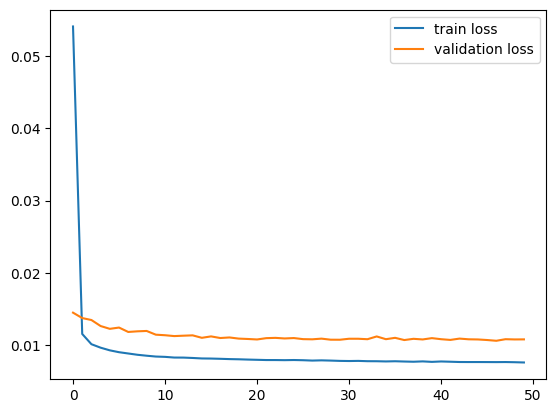

In [77]:
BATCH_SIZE=4
model = Sequential(name="LSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (2, 13)                   1404      
                                                                 
 dense_61 (Dense)            (2, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch2\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000813,0.000083,0.017945,0.009690,0.000938,0.004622,0.005469,0.006218,0.007095,0.000586,0.036113,0.014756,0.004747
R2,0.068126,-0.210312,0.068990,0.027192,0.300534,-0.026623,0.611898,0.145917,0.348560,0.986485,-0.055465,0.082158,0.646377


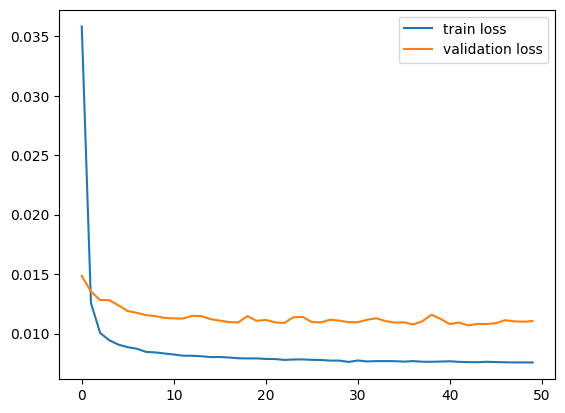

In [78]:
BATCH_SIZE=2
model = Sequential(name="LSTM13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (1, 13)                   1404      
                                                                 
 dense_62 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch1\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000971,0.000122,0.017952,0.009621,0.000957,0.004592,0.005615,0.005500,0.006777,0.000381,0.038183,0.014753,0.004838
R2,-0.112539,-0.786846,0.068649,0.034087,0.286965,-0.019909,0.601496,0.244507,0.377752,0.991227,-0.115971,0.082342,0.639535


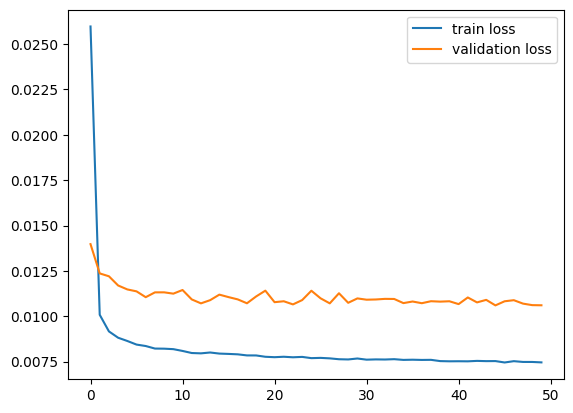

In [79]:
BATCH_SIZE=1
model = Sequential(name="LSTM13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

LSTM to LSTM

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 3, 32)             5888      
                                                                 
 lstm_31 (LSTM)              (None, 13)                2392      
                                                                 
 dense_63 (Dense)            (None, 13)                182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000848,0.000237,0.017755,0.010037,0.001014,0.004567,0.005772,0.006459,0.008616,0.001456,0.036988,0.014886,0.005667
R2,0.027961,-2.469090,0.078884,-0.007691,0.244585,-0.014351,0.590369,0.112774,0.208918,0.966442,-0.081041,0.074026,0.577783


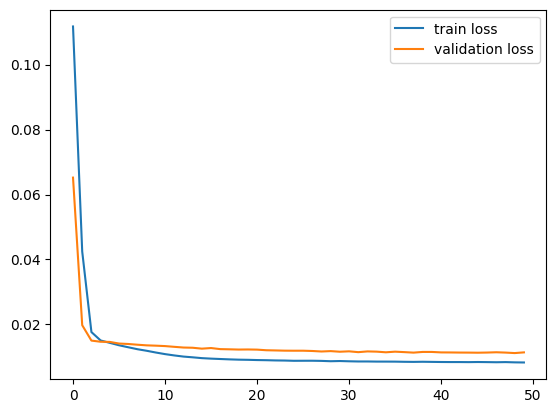

In [80]:
model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "LSTM64xLSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (4, 3, 32)                5888      
                                                                 
 lstm_33 (LSTM)              (4, 13)                   2392      
                                                                 
 dense_64 (Dense)            (4, 13)                   182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.000836,0.000352,0.018208,0.009789,0.000978,0.004670,0.006035,0.005834,0.007396,0.000460,0.041224,0.014995,0.006451
R2,0.041398,-4.148283,0.055390,0.017218,0.271269,-0.037124,0.571706,0.198617,0.320981,0.989402,-0.204844,0.067263,0.519382


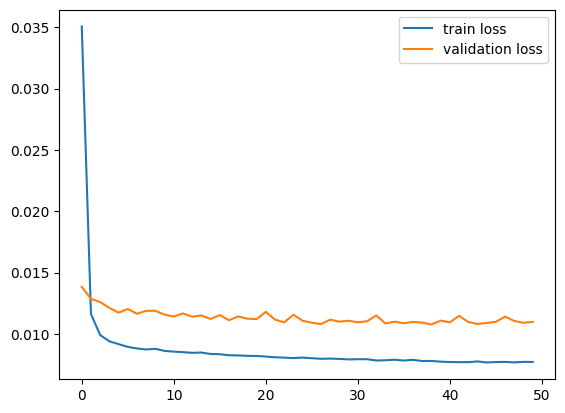

In [81]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM64_LSTM32_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 3, 64)             19968     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dense_65 (Dense)            (None, 13)                429       
                                                                 
Total params: 32,813
Trainable params: 32,813
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64_LSTM32_Dense\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64_LSTM32_Dense\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001144,0.000145,0.017775,0.009862,0.000955,0.004621,0.005402,0.006246,0.008316,0.002264,0.038759,0.014928,0.005170
R2,-0.311532,-1.117547,0.077805,0.009912,0.288079,-0.026272,0.616618,0.142053,0.236513,0.947822,-0.132797,0.071473,0.614795


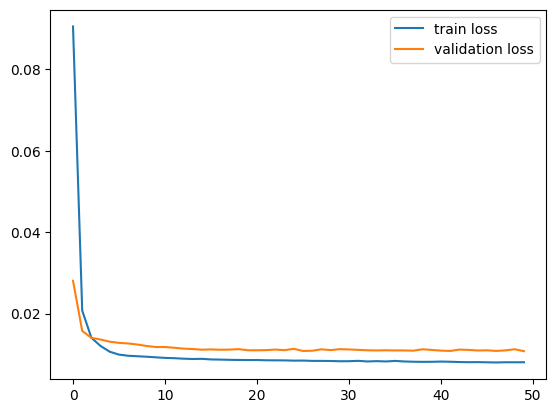

In [82]:
model = Sequential(name="LSTM64_LSTM32_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

#### GRU

Model: "GRU13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 13)                1092      
                                                                 
 dense_23 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001544,0.000554,0.000375,0.010443,0.000191,0.011944,0.006503,0.006572,0.009888,0.034100,0.059668,0.000779,0.005362
R2,0.033821,-0.141587,-0.326127,-0.019602,0.202066,0.119772,0.372626,-0.026881,0.450568,0.463276,-0.001362,0.009669,0.572986


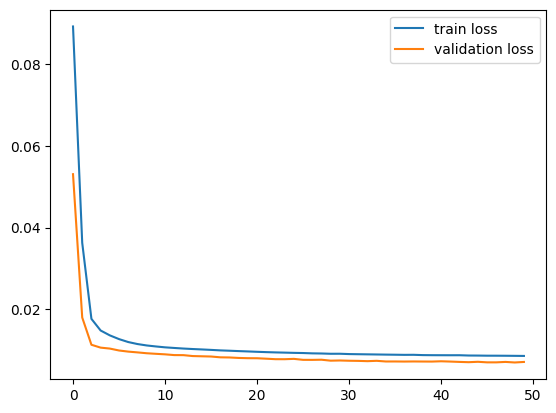

In [46]:
model = Sequential(name="GRU13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE = 8
model = Sequential(name="GRU13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (4, 13)                   1092      
                                                                 
 dense_24 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001556,0.000174,0.000416,0.010124,0.000167,0.012211,0.006444,0.005014,0.009496,0.033541,0.060821,0.000793,0.005046
R2,0.026465,0.641080,-0.469290,0.011551,0.303503,0.100112,0.378348,0.216596,0.472351,0.472076,-0.020711,-0.008273,0.598185


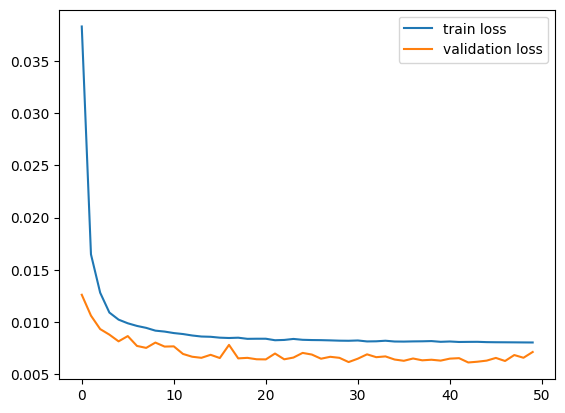

In [47]:
BATCH_SIZE = 4
model = Sequential(name="GRU13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

In [ ]:
BATCH_SIZE = 2
model = Sequential(name="GRU13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

In [ ]:
BATCH_SIZE = 1
model = Sequential(name="GRU13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

In [ ]:
model = Sequential(name="GRU32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
model = Sequential(name="GRU32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE = 4
model = Sequential(name="GRU13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

In [ ]:
model = Sequential(name="LSTM64_LSTM32_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
model = Sequential(name="LSTM64_LSTM32_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(32, return_sequences=True))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

In [ ]:
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Faltten2Layers_Window1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 39)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                1280      
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 13)                429       
                                                                 
Total params: 2,765
Trainable params: 2,765
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - 1s 8ms/step - loss: 0.0952 - val_loss: 0.0499
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.03

INFO:tensorflow:Assets written to: models_w3/Faltten2Layers_Window1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001755,0.000298,0.000584,0.011088,0.000467,0.011817,0.007109,0.006285,0.009915,0.032715,0.060593,0.000767,0.005826
R2,-0.098405,0.385574,-1.063893,-0.082592,-0.951038,0.129163,0.314187,0.017944,0.449033,0.485070,-0.016894,0.024612,0.536032


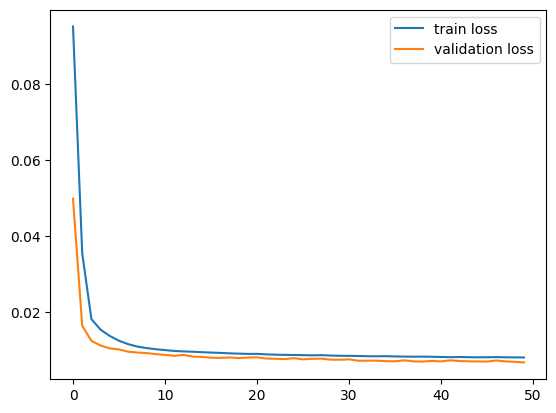

In [48]:
BATCH_SIZE=4
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [ ]:
BATCH_SIZE=4
model = Sequential(name="Faltten2Layers_Window1")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

## Train with static parameters


Lets define new function for splitting

In [88]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_data_with_static(df_input=df, window=3)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[1:], y_train[1:]), (X_test[1:], y_test[1:]), (X_val[2:], y_val[2:])

#### FNN

Flatten3Layers_Mixed

Model: "Flatten3Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 141)               0         
                                                                 
 dense_98 (Dense)            (None, 128)               18176     
                                                                 
 dense_99 (Dense)            (None, 64)                8256      
                                                                 
 dense_100 (Dense)           (None, 32)                2080      
                                                                 
 dense_101 (Dense)           (None, 13)                429       
                                                                 
Total params: 28,941
Trainable params: 28,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [========================

INFO:tensorflow:Assets written to: models_w3/Flatten3Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002314,0.000932,0.000783,0.022283,0.000521,0.002157,0.007378,0.005359,0.014616,0.003276,0.073314,0.001249,0.006749
R2,-0.869606,0.893373,-0.657449,-0.249351,-0.926087,-0.723951,0.245235,0.151777,0.411854,0.964318,-0.532127,-0.586285,0.443858


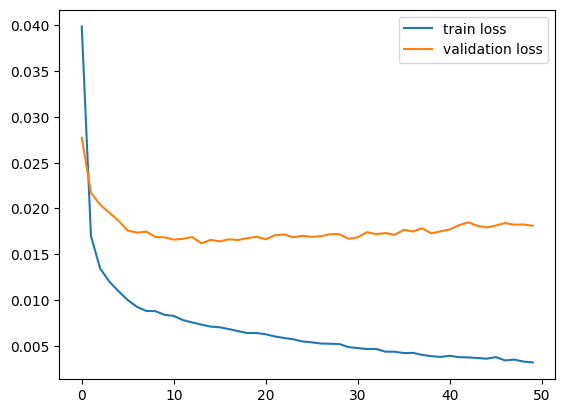

In [98]:
model = Sequential(name="Flatten3Layers_Mixed")
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Flatten4Layers_Mixed

Model: "Flatten4Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 141)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               18176     
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dense_83 (Dense)            (None, 64)                4160      
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
 dense_85 (Dense)            (None, 13)                429       
                                                                 
Total params: 33,101
Trainable params: 33,101


INFO:tensorflow:Assets written to: models_w3/Flatten4Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002207,0.002799,0.000618,0.023734,0.000780,0.002310,0.006714,0.006102,0.012617,0.002506,0.075605,0.001012,0.008090
R2,-0.782700,0.679658,-0.307452,-0.330670,-1.881357,-0.846059,0.313146,0.034158,0.492316,0.972704,-0.580006,-0.285469,0.333398


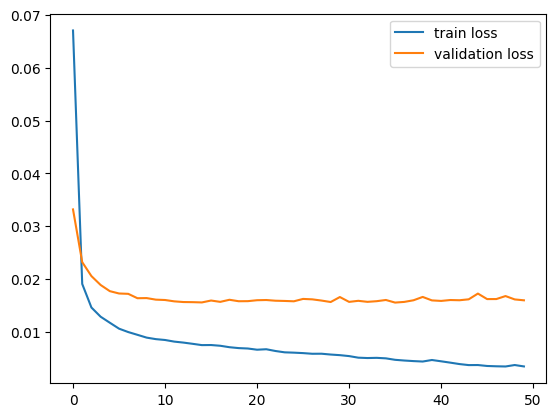

In [90]:
model = Sequential(name="Flatten4Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Flatten5Layers_Mixed

Model: "Flatten5Layers_Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 141)               0         
                                                                 
 dense_102 (Dense)           (None, 128)               18176     
                                                                 
 dense_103 (Dense)           (None, 64)                8256      
                                                                 
 dense_104 (Dense)           (None, 64)                4160      
                                                                 
 dense_105 (Dense)           (None, 64)                4160      
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dense_107 (Dense)           (None, 13)       

INFO:tensorflow:Assets written to: models_w3/Flatten5Layers_Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002074,0.000622,0.000477,0.027378,0.000199,0.001409,0.007832,0.005951,0.013397,0.002230,0.078508,0.000837,0.006384
R2,-0.675327,0.928876,-0.009905,-0.534989,0.262803,-0.126136,0.198753,0.058060,0.460920,0.975716,-0.640667,-0.063173,0.473956


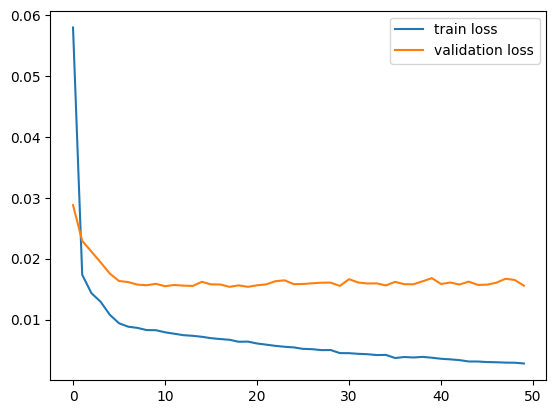

In [99]:
model = Sequential(name="Flatten5Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

In [93]:
y_train.shape

(711, 13)

In [101]:
BATCH_SIZE=4
model = Sequential(name="Flatten5Layers_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

TypeError: Invalid keyword argument(s) in `compile()`: ({'batch_size'},). Valid keyword arguments include "cloning", "experimental_run_tf_function", "distribute", "target_tensors", or "sample_weight_mode".

#### RNN

RNN

In [ ]:
RNN_LENGTH = PARAM_LENGTH+TARGET_LENGTH
model = Sequential("RNN32Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(RNN_LENGTH, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

Model: "LSTM_StatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                28672     
                                                                 
 dense_28 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 2s 7ms/step - loss: 0.0338 - val_loss: 0.0157
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 4/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 5/50
105/105 [========================

INFO:tensorflow:Assets written to: models_w3/LSTM_StatDynam\assets


INFO:tensorflow:Assets written to: models_w3/LSTM_StatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001554,0.000184,0.000290,0.007212,0.000149,0.001896,0.006167,0.007191,0.00922,0.000293,0.068481,0.000598,0.004936
R2,-0.112844,0.044098,0.023333,-0.066865,0.397859,0.054479,0.632094,0.216932,0.44063,0.995301,-0.045183,0.210255,0.619793


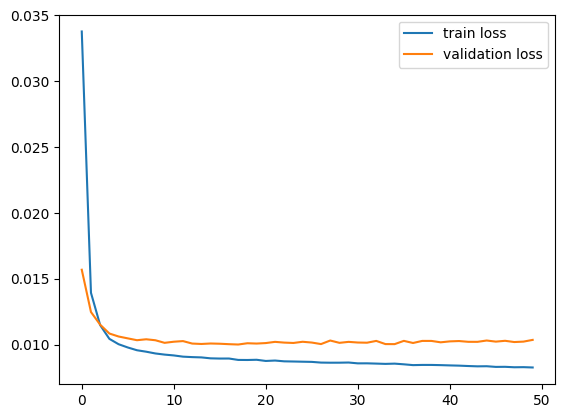

In [50]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
model = Sequential("LSTM64Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

Here we will take dynamic and static params aparted

In [51]:
D_train = X_train[:, :, 29:]
S_train = X_train[:, 0, 0:29]
S_train = np.hstack([S_train, X_train[:, 0, 42:43]])
D_val = X_val[:, :, 29:]
S_val = X_val[:, 0, :29]
S_val = np.hstack([S_val, X_val[:, 0, 42:43]])


Model: "StaticDense_DynamicLSTM_oneLayer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_17 (LSTM)                 (None, 40)           9440        ['input_29[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 16)           496         ['input_28[0][0]']               
                                                                   

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_oneLayer\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_oneLayer\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001725,0.000063,0.004062,0.010225,0.000257,0.001178,0.006220,0.007178,0.011120,0.007738,0.068198,0.004867,0.005711
R2,0.032918,-0.104081,0.092533,-0.014513,0.280060,0.142073,0.571214,0.345500,0.287068,0.812218,0.035000,0.095090,0.592805


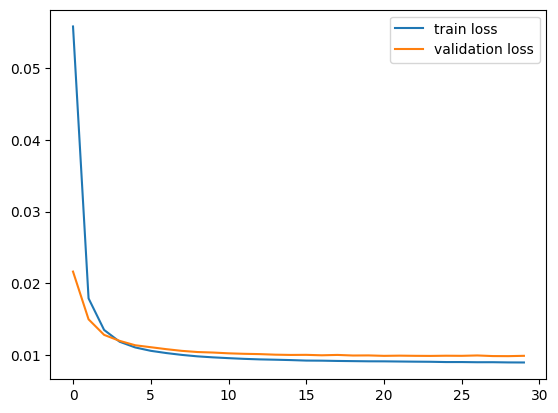

In [52]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model = Model(name="StaticDense_DynamicLSTM_oneLayer", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")

history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
show_results([S_val, D_val], y_val, model, history)

Lets use linear activation to compare results

Model: "StaticDense_DynamicLSTM_twoLayers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 64)           21248       ['input_31[0][0]']               
                                                                                                  
 dense_31 (Dense)               (None, 32)           992         ['input_30[0][0]']               
                                                                  

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_twoLayers\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_twoLayers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001792,0.000119,0.004152,0.010735,0.000286,0.001336,0.006333,0.007372,0.010722,0.007732,0.079551,0.004900,0.005180
R2,-0.004507,-1.087537,0.072425,-0.065076,0.198969,0.027222,0.563426,0.327791,0.312623,0.812369,-0.125641,0.089013,0.630691


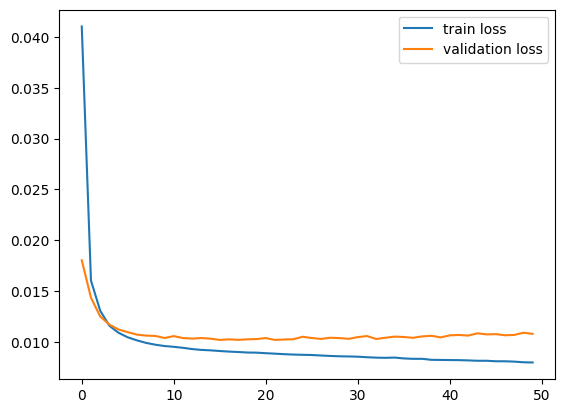

In [53]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = LSTM(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicLSTM_twoLayers", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)

Model: "StaticDense_DynamicGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 64)           16128       ['input_33[0][0]']               
                                                                                                  
 dense_34 (Dense)               (None, 32)           992         ['input_32[0][0]']               
                                                                             

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicGRU\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicGRU\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001876,0.000119,0.004010,0.011439,0.000258,0.001264,0.005979,0.007604,0.010576,0.007806,0.078441,0.004762,0.005196
R2,-0.051543,-1.093470,0.104122,-0.134941,0.278475,0.079770,0.587839,0.306683,0.321981,0.810567,-0.109938,0.114653,0.629507


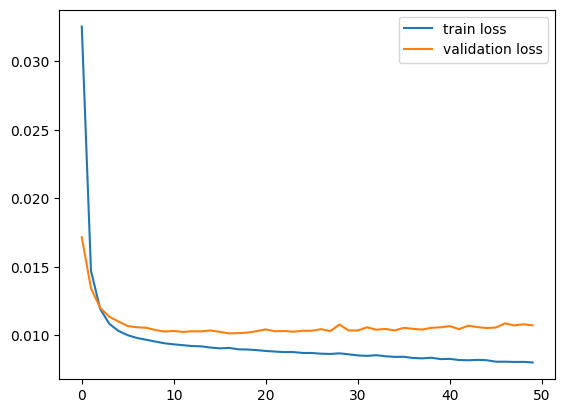

In [54]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
WINDOW=1
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = GRU(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicGRU", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)